Run an EasyVVUQ campaign to analyze the sensitivity of the Ishigami function

This is done with SC.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.20.3'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(sc_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_sc.')


    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=define_vary(), polynomial_order=sc_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate(progress_bar=True)

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

In [8]:
# Calculate the stochastic collocation expansion for a range of orders

R = {}
for sc_order in range(1, 21):
    R[sc_order] = {}
    (R[sc_order]['results_df'], 
     R[sc_order]['results'], 
     R[sc_order]['times'], 
     R[sc_order]['order'], 
     R[sc_order]['number_of_samples']) = run_campaign(sc_order=sc_order, use_files=False)

100%|██████████| 8/8 [00:00<00:00, 940.64it/s]

Time for phase 1 = 0.044
Number of samples = 8
Time for phase 2 = 0.045
Time for phase 3 = 0.027
Time for phase 4 = 0.016
Time for phase 5 = 0.023
Time for phase 6 = 0.002
Time for phase 1 = 0.019



100%|██████████| 27/27 [00:00<00:00, 2785.54it/s]


Number of samples = 27
Time for phase 2 = 0.076
Time for phase 3 = 0.019
Time for phase 4 = 0.004
Time for phase 5 = 0.040
Time for phase 6 = 0.003
Time for phase 1 = 0.018


100%|██████████| 64/64 [00:00<00:00, 2152.86it/s]

Number of samples = 64
Time for phase 2 = 0.145
Time for phase 3 = 0.044
Time for phase 4 = 0.009
Time for phase 5 = 0.105
Time for phase 6 = 0.003


Time for phase 1 = 0.044
Number of samples = 125
Time for phase 2 = 0.210


100%|██████████| 125/125 [00:00<00:00, 2963.33it/s]


Time for phase 3 = 0.060
Time for phase 4 = 0.009
Time for phase 5 = 0.131
Time for phase 6 = 0.002
Time for phase 1 = 0.017


100%|██████████| 216/216 [00:00<00:00, 3375.84it/s]

Number of samples = 216
Time for phase 2 = 0.238
Time for phase 3 = 0.078
Time for phase 4 = 0.008


Time for phase 5 = 0.293
Time for phase 6 = 0.003
Time for phase 1 = 0.024


100%|██████████| 343/343 [00:00<00:00, 4233.40it/s]

Number of samples = 343
Time for phase 2 = 0.348
Time for phase 3 = 0.103
Time for phase 4 = 0.011


Time for phase 5 = 0.457
Time for phase 6 = 0.005
Time for phase 1 = 0.034


100%|██████████| 512/512 [00:00<00:00, 4486.04it/s]

Number of samples = 512
Time for phase 2 = 0.563
Time for phase 3 = 0.137
Time for phase 4 = 0.014


Time for phase 5 = 0.545
Time for phase 6 = 0.008
Time for phase 1 = 0.037


100%|██████████| 729/729 [00:00<00:00, 4553.03it/s]

Number of samples = 729
Time for phase 2 = 0.456
Time for phase 3 = 0.194


Time for phase 4 = 0.018
Time for phase 5 = 0.721
Time for phase 6 = 0.005
Time for phase 1 = 0.026


 44%|████▍     | 442/1000 [00:00<00:00, 4418.19it/s]

Number of samples = 1000
Time for phase 2 = 0.612


100%|██████████| 1000/1000 [00:00<00:00, 4381.37it/s]


Time for phase 3 = 0.266
Time for phase 4 = 0.029
Time for phase 5 = 1.033
Time for phase 6 = 0.006
Time for phase 1 = 0.025


 30%|███       | 405/1331 [00:00<00:00, 4035.10it/s]

Number of samples = 1331
Time for phase 2 = 0.931


100%|██████████| 1331/1331 [00:00<00:00, 3897.26it/s]


Time for phase 3 = 0.390
Time for phase 4 = 0.031
Time for phase 5 = 1.407
Time for phase 6 = 0.012
Time for phase 1 = 0.033
Number of samples = 1728
Time for phase 2 = 1.003


100%|██████████| 1728/1728 [00:00<00:00, 3370.05it/s]


Time for phase 3 = 0.753
Time for phase 4 = 0.053
Time for phase 5 = 2.527
Time for phase 6 = 0.011
Time for phase 1 = 0.028
Number of samples = 2197
Time for phase 2 = 1.260


100%|██████████| 2197/2197 [00:00<00:00, 4021.69it/s]


Time for phase 3 = 0.773
Time for phase 4 = 0.079
Time for phase 5 = 2.388
Time for phase 6 = 0.007
Time for phase 1 = 0.019


 19%|█▊        | 514/2744 [00:00<00:00, 5130.82it/s]

Number of samples = 2744
Time for phase 2 = 1.476


100%|██████████| 2744/2744 [00:00<00:00, 5031.89it/s]


Time for phase 3 = 0.630
Time for phase 4 = 0.135
Time for phase 5 = 3.027
Time for phase 6 = 0.055
Time for phase 1 = 0.041
Number of samples = 3375
Time for phase 2 = 1.584


100%|██████████| 3375/3375 [00:00<00:00, 3976.55it/s]


Time for phase 3 = 1.068
Time for phase 4 = 0.079
Time for phase 5 = 4.012
Time for phase 6 = 0.018
Time for phase 1 = 0.025
Number of samples = 4096
Time for phase 2 = 2.015


100%|██████████| 4096/4096 [00:00<00:00, 4329.78it/s]


Time for phase 3 = 1.173
Time for phase 4 = 0.240
Time for phase 5 = 6.876
Time for phase 6 = 0.022
Time for phase 1 = 0.029
Number of samples = 4913
Time for phase 2 = 3.027


100%|██████████| 4913/4913 [00:01<00:00, 2775.14it/s]


Time for phase 3 = 2.001
Time for phase 4 = 0.284
Time for phase 5 = 8.112
Time for phase 6 = 0.025
Time for phase 1 = 0.034
Number of samples = 5832
Time for phase 2 = 2.935


100%|██████████| 5832/5832 [00:01<00:00, 4304.04it/s]


Time for phase 3 = 1.595
Time for phase 4 = 0.317
Time for phase 5 = 11.989
Time for phase 6 = 0.048
Time for phase 1 = 0.064
Number of samples = 6859
Time for phase 2 = 4.160


100%|██████████| 6859/6859 [00:01<00:00, 3865.79it/s]


Time for phase 3 = 2.020
Time for phase 4 = 0.296
Time for phase 5 = 11.716
Time for phase 6 = 0.030
Time for phase 1 = 0.034
Number of samples = 8000
Time for phase 2 = 4.110


100%|██████████| 8000/8000 [00:02<00:00, 3496.31it/s]


Time for phase 3 = 2.624
Time for phase 4 = 0.206
Time for phase 5 = 15.051
Time for phase 6 = 0.043
Time for phase 1 = 0.034
Number of samples = 9261
Time for phase 2 = 4.660


100%|██████████| 9261/9261 [00:02<00:00, 3531.32it/s]


Time for phase 3 = 2.939
Time for phase 4 = 0.264
Time for phase 5 = 18.864
Time for phase 6 = 0.139


In [9]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [10]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.158249,0.044463,0.045157,0.027455,0.015654,0.023364,0.001825
2,0.159667,0.018620,0.075858,0.018592,0.003819,0.039893,0.002594
3,0.323880,0.017593,0.145160,0.044086,0.008541,0.104988,0.003109
4,0.454608,0.043664,0.209539,0.059554,0.008784,0.131073,0.001588
5,0.637004,0.016862,0.237678,0.078054,0.008347,0.293213,0.002509
6,0.949501,0.023694,0.348445,0.103378,0.011489,0.457311,0.004618
7,1.301590,0.034174,0.562767,0.137497,0.013694,0.545244,0.007882
8,1.432124,0.037351,0.456433,0.193846,0.018405,0.720531,0.004730
9,1.974014,0.025784,0.611962,0.265501,0.029102,1.033048,0.005515
10,2.797863,0.024832,0.930756,0.390384,0.031481,1.407211,0.011949


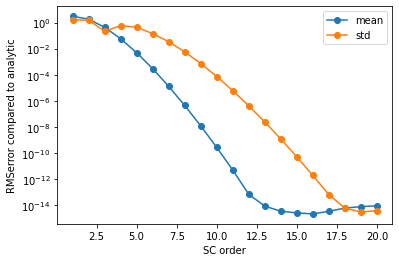

In [11]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('SC order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

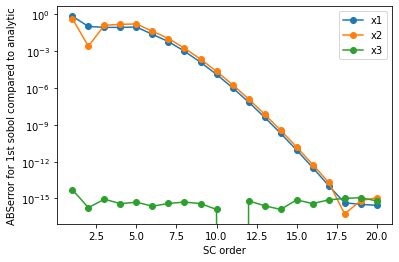

In [12]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('SC order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

In [13]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate(progress_bar=True)
test_df = test_campaign.get_collation_result()

100%|██████████| 1000/1000 [00:00<00:00, 3661.17it/s]


In [14]:
# calculate the SC surrogates
if __name__ == '__main__':

    test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
    test_results = np.squeeze(test_df['Ishigami'].values)
    test_predictions = {}
    for i in list(R.keys()):
        test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

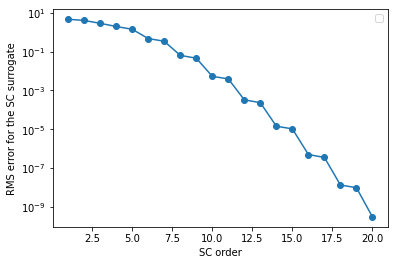

In [15]:
# plot the convergence of the surrogate
if __name__ == '__main__':
    _o = []
    _RMS = []
    for r in R.values():
        _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
        _o.append(r['order'])

    plt.figure()
    plt.semilogy(_o, _RMS, 'o-')
    plt.xlabel('SC order')
    plt.ylabel('RMS error for the SC surrogate')
    plt.legend(loc=0)
    plt.savefig('Convergence_SC_surrogate.png')
    plt.savefig('Convergence_SC_surrogate.pdf')